In [1]:
cd /home/admin/projects/course22p2

/home/admin/projects/course22p2


## Load data

In [2]:
import logging
logging.disable(logging.WARNING)

In [3]:
!jupyter notebook --version # 6.4.6

6.5.4


In [4]:
from datasets import load_dataset,load_dataset_builder
import torch
import torchvision.transforms.functional as TF
from miniai.datasets import *

x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)).view(-1, 28, 28) for o in b[x]]

bs = 1024
tds = dsd.with_transform(transformi)

dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

  0%|          | 0/2 [00:00<?, ?it/s]

(torch.Size([1024, 1, 28, 28]), tensor([8, 3, 7, 4, 1, 0, 9, 9, 1, 9]))

## Create sequence

In [5]:
from miniai.conv import conv
from torch import nn

## Create model

In [6]:
import torch
import numpy as np

class TinyModel(torch.nn.Module):

    def __init__(self, layers):
        super(TinyModel, self).__init__()
        self.layers = nn.Sequential(*layers)
        self.means = [[] for _ in self.layers]
        self.hists = [[] for _ in self.layers]
        self.stds = [[] for _ in self.layers]
    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            self.means[i].append(x.detach().abs().mean().item())
            self.stds[i].append(x.detach().abs().std().item())
            self.hists[i].append(x.detach().cpu().abs().histc(40,0,4))
        return x

layers = [conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,16),           #2x2
    conv(16,10, act=False), #1x1
    nn.Flatten()]
model = TinyModel(layers)

In [7]:
# model(xb)
# model.means

accuracy,loss,epoch,train
0.153,2.290,0,train
0.209,2.241,0,eval


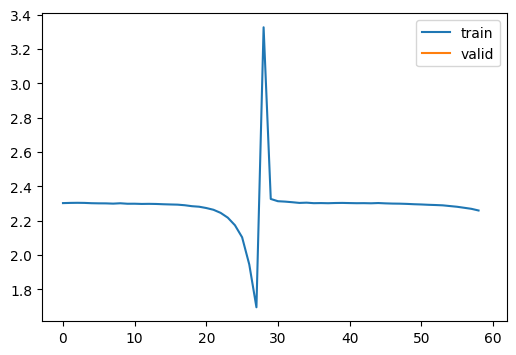

In [8]:
from miniai.learner import Learner, TrainCB, DeviceCB, MetricsCB, ProgressCB
import torch.nn.functional as F
from torcheval.metrics import MulticlassAccuracy,Mean

metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.6, cbs=cbs)
learn.fit(1)

## Plot mean std hist

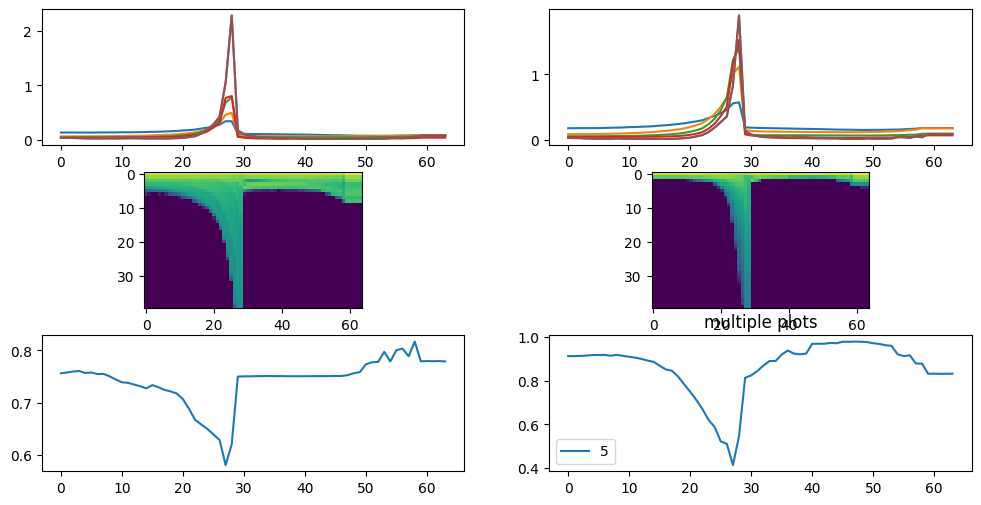

In [9]:
import matplotlib.pyplot as plt


fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,6))
for i, mean in enumerate(model.means):
    axes[0][0].plot(mean, label=i)
for i, std in enumerate(model.stds):
    axes[0][1].plot(std, label=i)
    
axes[1][0].imshow(torch.stack(model.hists[1]).t().float().log1p())
axes[1][1].imshow(torch.stack(model.hists[3]).t().float().log1p())

axes[2][0].plot([hist[0] / hist.sum() for hist in model.hists[1]], label=i)
axes[2][1].plot([hist[0] / hist.sum() for hist in model.hists[3]], label=i)

plt.legend()
plt.title('multiple plots')
plt.show()

In [10]:
model.hists[3][0][0] / model.hists[3][0].sum()

tensor(0.9121)

## Hook

In [11]:
class StatsHook:
    def __init__(self):
        self.means = []
        self.stds = []
        self.hists = []
    def __call__(self, module, module_input, x):
        self.means.append(x.abs().mean().item())
        self.stds.append(x.abs().std().item())
        self.hists.append(x.detach().cpu().abs().histc(40,0,4))
        
    def clear(self):
        self.means = []
        self.stds = []


In [12]:
class TinyModel(torch.nn.Module):

    def __init__(self, layers, hooks):
        super(TinyModel, self).__init__()
        self.layers = nn.Sequential(*layers)
        for hook, layer in zip(hooks, self.layers): layer.register_forward_hook(hook)

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
        return x

layers = [conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,16),           #2x2
    conv(16,10, act=False), #1x1
    nn.Flatten()]
hooks = [StatsHook() for _ in layers]
model = TinyModel(layers, hooks)

accuracy,loss,epoch,train
0.154,2.292,0,train
0.166,2.298,0,eval


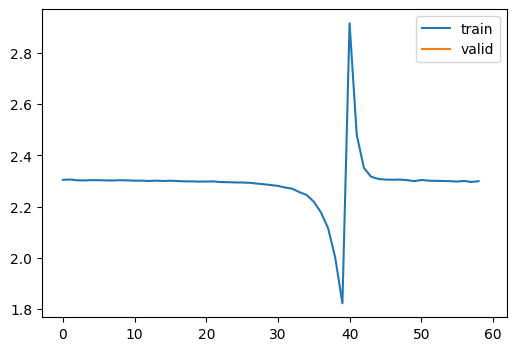

In [13]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.6, cbs=cbs)
learn.fit(1)

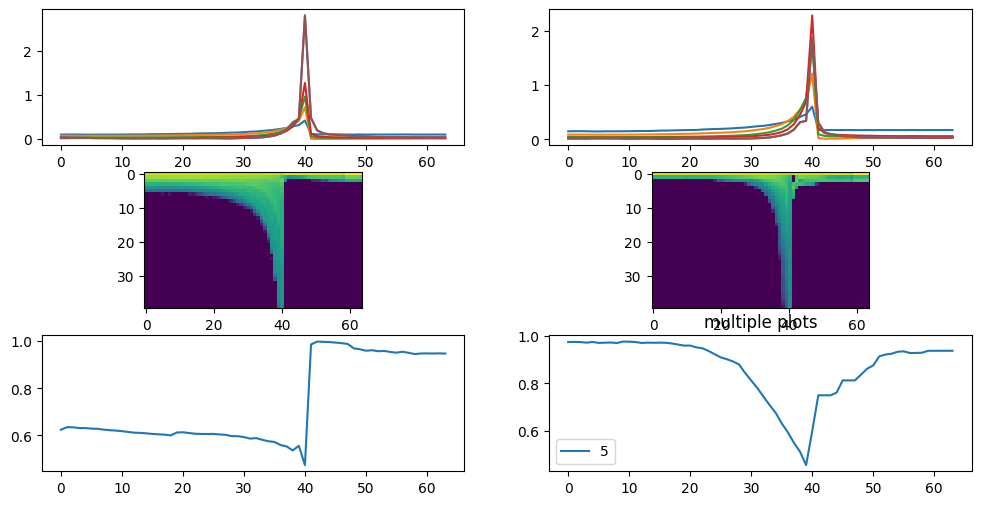

In [14]:
import matplotlib.pyplot as plt


fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,6))
for i, hook in enumerate(hooks):
    axes[0][0].plot(hook.means, label=i)
for i, hook in enumerate(hooks):
    axes[0][1].plot(hook.stds, label=i)
    
axes[1][0].imshow(torch.stack(hooks[1].hists).t().float().log1p())
axes[1][1].imshow(torch.stack(hooks[3].hists).t().float().log1p())

axes[2][0].plot([hist[0] / hist.sum() for hist in hooks[1].hists], label=i)
axes[2][1].plot([hist[0] / hist.sum() for hist in hooks[3].hists], label=i)

plt.legend()
plt.title('multiple plots')
plt.show()

## Context manager

In [15]:
class HookManager:
    def __init__(self, model):
        self.hooks = [StatsHook() for _ in model.layers]
        self.model = model
            
    def __enter__(self):
        for hook, layer in zip(self.hooks, self.model.layers): layer.register_forward_hook(hook)

    def __exit__(self, exc_type, exc_value, exc_traceback):
        fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,6))
        for i, hook in enumerate(self.hooks):
            axes[0][0].plot(hook.means, label=i)
        for i, hook in enumerate(self.hooks):
            axes[0][1].plot(hook.stds, label=i)
            
        axes[1][0].imshow(torch.stack(self.hooks[1].hists).t().float().log1p())
        axes[1][1].imshow(torch.stack(self.hooks[3].hists).t().float().log1p())

        axes[2][0].plot([hist[0] / hist.sum() for hist in self.hooks[1].hists], label=i)
        axes[2][1].plot([hist[0] / hist.sum() for hist in self.hooks[3].hists], label=i)

In [20]:
class TinyModel(torch.nn.Module):

    def __init__(self, layers):
        super(TinyModel, self).__init__()
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
        return x
    
layers = [conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,16),           #2x2
    conv(16,10, act=False), #1x1
    nn.Flatten()]
model = TinyModel(layers)

accuracy,loss,epoch,train
0.140,2.309,0,train
0.100,2.307,0,eval


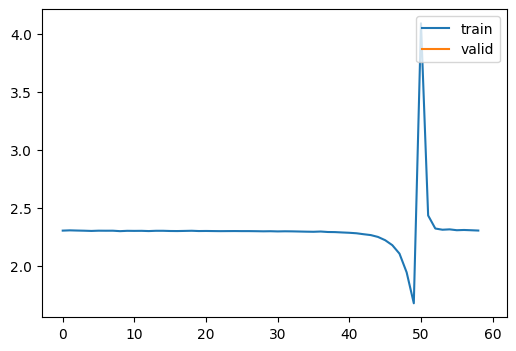

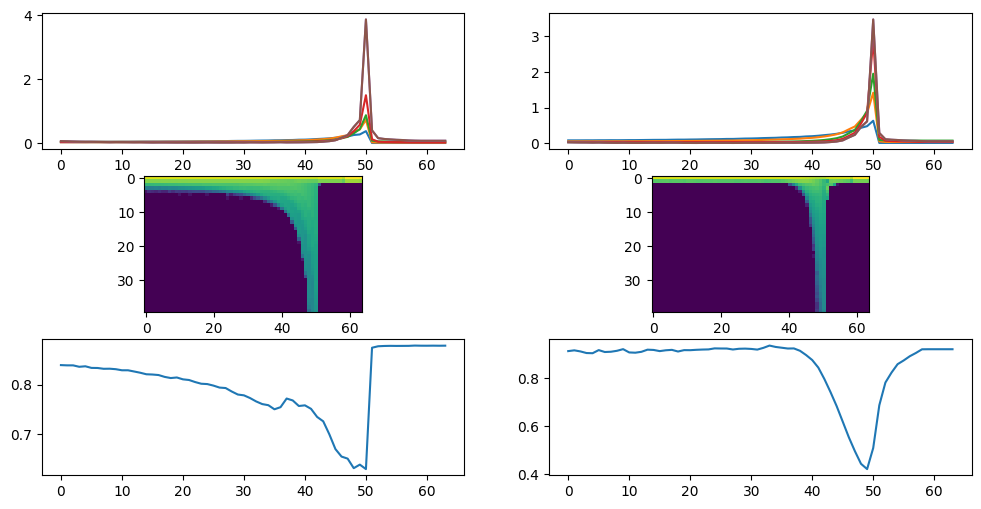

In [21]:
with HookManager(model):
    metrics = MetricsCB(accuracy=MulticlassAccuracy())
    cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
    learn = Learner(model, dls, F.cross_entropy, lr=0.6, cbs=cbs)
    learn.fit(1)

In [19]:
# CallBack

{'accuracy': '0.287', 'loss': '1.935', 'epoch': 0, 'train': 'train'}
{'accuracy': '0.499', 'loss': '1.455', 'epoch': 0, 'train': 'eval'}


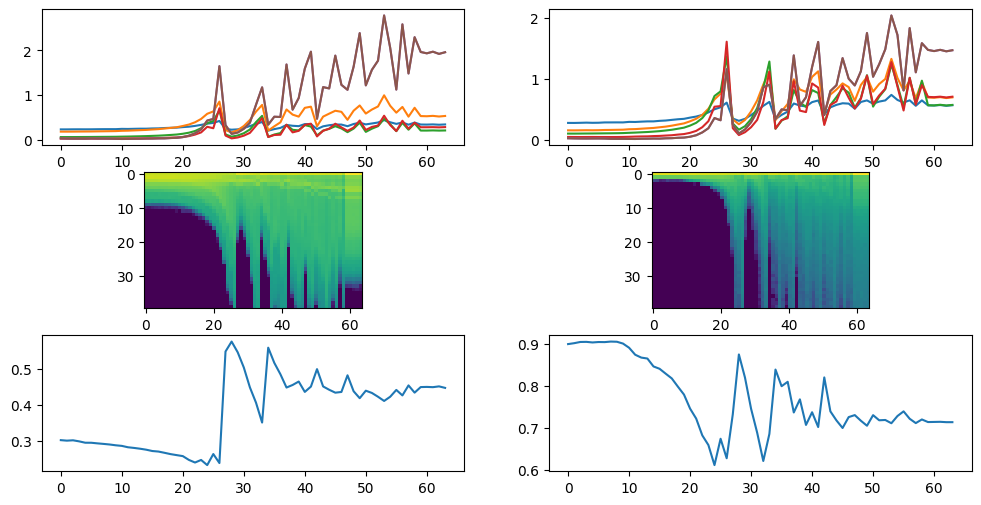

In [34]:
from miniai.learner import Callback
from miniai.learner import TrainLearner

class HookCB(Callback):
    def before_fit(self, learn):
        self.hooks = [StatsHook() for _ in learn.model.layers]
        for hook, layer in zip(self.hooks, learn.model.layers): layer.register_forward_hook(hook)
    def after_fit(self, learn):
        fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,6))
        for i, hook in enumerate(self.hooks):
            axes[0][0].plot(hook.means, label=i)
        for i, hook in enumerate(self.hooks):
            axes[0][1].plot(hook.stds, label=i)
            
        axes[1][0].imshow(torch.stack(self.hooks[1].hists).t().float().log1p())
        axes[1][1].imshow(torch.stack(self.hooks[3].hists).t().float().log1p())

        axes[2][0].plot([hist[0] / hist.sum() for hist in self.hooks[1].hists], label=i)
        axes[2][1].plot([hist[0] / hist.sum() for hist in self.hooks[3].hists], label=i)

class TinyModel(torch.nn.Module):

    def __init__(self, layers):
        super(TinyModel, self).__init__()
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
        return x
    
layers = [conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,16),           #2x2
    conv(16,10, act=False), #1x1
    nn.Flatten()]
model = TinyModel(layers)


metrics = MetricsCB(accuracy=MulticlassAccuracy())
hook = HookCB()
cbs = [DeviceCB(), metrics, hook]
learn = TrainLearner(model, dls, F.cross_entropy, lr=0.6, cbs=cbs)
learn.fit(1)